In [1]:
import numpy as np
import scipy.io
import pandas as pd
import csv
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from torchviz import make_dot

In [3]:
print(torch.__version__)

2.3.0+cu121


In [3]:
from point_net import PointNetBackbone
from utils import normalize_point_cloud, find_surface_indices, chamfer_distance

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# import nibabel as nib
import os
import warnings
warnings.filterwarnings("ignore")

In [5]:
save_dir = 'generative_multistructural_delta'   
os.makedirs(save_dir, exist_ok=True)
BATCH_SIZE = 36
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [6]:
point_clouds_info = pd.read_csv('point_Clouds_info.csv');
dataI = pd.read_csv('dataI_with_stage.csv') ; dataI = dataI.drop('Unnamed: 0', axis = 1)
dataP = pd.read_csv('dataP_with_stage.csv') ; dataP = dataP.drop('Unnamed: 0', axis = 1)
dataTrack = pd.read_csv('dataTrack_with_stage.csv') ; dataTrack = dataTrack.drop('Unnamed: 0', axis = 1)
dataP['subjid'] = dataP['subjid'].astype(str)  # so that we can work with sklearn group split
dataSet  = pd.concat([dataI, dataP, dataTrack])
print(dataSet.shape)
patients = dataSet.loc[dataSet['group'] != 'control']
patients.reset_index(drop=True , inplace = True)
print(patients.shape)

(4407, 308)
(2932, 308)


In [7]:
patients['Disease_Stage'] = patients['Disease_Stage'].apply(lambda x: int(x[6]) if not x.startswith('Error') else np.NaN)
# patients = patients[~np.isnan(patients['Disease_Stage'])] # Drop empty rows (where 'error' was the prefix)
imputer = KNNImputer(n_neighbors=15, weights="uniform")
numeric_columns = patients.select_dtypes(include='number').columns
patients.loc[:,numeric_columns] = pd.DataFrame(imputer.fit_transform(patients[numeric_columns]), columns=numeric_columns)

patients.reset_index(drop=True)
patients['Disease_Stage'] = patients['Disease_Stage'].round(0).astype(int).astype(str)
print(patients.shape)

(2932, 308)


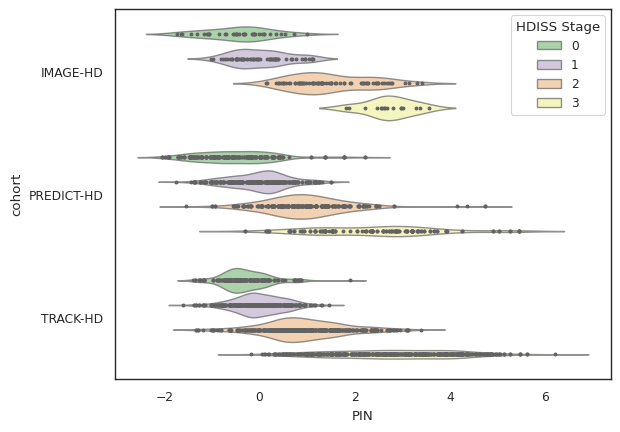

In [8]:
sns.set_theme(style="white", palette="Accent")
sns.set_context("paper")

ax = sns.violinplot(y = 'cohort' , x ='PIN' , data = patients, alpha = 0.7, 
                   hue='Disease_Stage' , hue_order=['0' , '1', '2' ,'3'] , inner="points")

plt.legend(title='HDISS Stage')

In [9]:
patients.groupby(['Disease_Stage'])['ageAtscan'].count()

Disease_Stage
0    516
1    836
2    851
3    729
Name: ageAtscan, dtype: int64

In [10]:
patients['subjid'].nunique()

615

### Classes and Methods

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.subjects = dataframe['subjid'].unique()  # Get unique subjects 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry_row = self.data.iloc[idx]
        subjid = entry_row['subjid']

        subject_data = self.data[self.data['subjid'] == subjid]  # Get all time points

        if len(subject_data) > 1:
            # Ensure time_idx2 >= time_idx1
            time_idx1 = np.random.randint(0, len(subject_data))  # Can be any valid index
            time_idx2 = np.random.randint(time_idx1, len(subject_data))  # Starts from time_idx1
        else:
            # Only one time point available, so set both indices to 0
            time_idx1 = time_idx2 = 0
        
        row_t1 = subject_data.iloc[time_idx1]
        row_t2 = subject_data.iloc[time_idx2]

        def process_row(row):
            """Extracts point cloud and biomarker data from a row."""         
            file_path = row['identifier'] 
            point_clouds_row = point_clouds_info.loc[point_clouds_info['identifier'] == file_path]
            file_index = int(point_clouds_row['index'])

            # labels = [4, 10, 11, 12, 13, 26]
            # num_points = [2500, 2000, 2000, 2000, 1500, 400]

            labels = [4, 11]
            num_points = [2500, 2000]
            surface_indices = []

            for region_label, n_samples in zip(labels, num_points):
                n = int(point_clouds_row[f'n_{region_label}'])
                P = pd.read_csv(f'Point_clouds/{file_index}/region{region_label}.csv').to_numpy()
        
                if n_samples < n:
                    sampled_surface_indices = np.random.choice(n, size=n_samples, replace=False)
                else:
                    sampled_surface_indices = np.random.choice(n, size=n_samples, replace=True)
                    
                P = P[:,sampled_surface_indices]
                P = torch.Tensor(P)
                surface_indices.append(P)

            disease_stage = row['Disease_Stage']
            CAG = torch.tensor(row['cag'], dtype=torch.float).unsqueeze(-1)
            cuhdrs = torch.tensor(row['cUHDRS'], dtype=torch.float).unsqueeze(-1)
            
            icv = torch.tensor(row['EstimatedTotalIntraCranialVol'], dtype=torch.float).unsqueeze(-1)

            vol_4 =  torch.tensor(row['Left-Lateral-Ventricle'], dtype=torch.float).unsqueeze(-1)
            # vol_10 = torch.tensor(row['Left-Thalamus'], dtype=torch.float).unsqueeze(-1)
            vol_11 =  torch.tensor(row['Left-Caudate'], dtype=torch.float).unsqueeze(-1)
            # vol_12 =  torch.tensor(row['Left-Putamen'], dtype=torch.float).unsqueeze(-1)
            # vol_13 =  torch.tensor(row['Left-Pallidum'], dtype=torch.float).unsqueeze(-1)
            # vol_26 =  torch.tensor(row['Left-Accumbens-area'], dtype=torch.float).unsqueeze(-1)
            
            # target = torch.cat((cuhdrs, vol_4, vol_10, vol_11, vol_12, vol_13, vol_26), dim = 0)
            target = torch.cat((cuhdrs, vol_4,  vol_11), dim = 0)
            
            age = torch.tensor(row['ageAtscan'] , dtype=torch.float).unsqueeze(-1)
            sex = torch.tensor(row['sex'] == 'male', dtype=torch.float).unsqueeze(-1)
            CAP = torch.tensor(row['CAP'], dtype=torch.float).unsqueeze(-1)
            cond = torch.cat((age , sex  , CAP), dim = 0)

            return (*surface_indices, cond, target , disease_stage , CAG , icv)

        # Process both randomly selected time points
        P4_t1, P11_t1, cond_t1, target_t1, disease_stage_t1 , CAG_t1 , icv_t1 = process_row(row_t1)
        P4_t2, P11_t2, cond_t2, target_t2, disease_stage_t2 , CAG_t2 , icv_t2 = process_row(row_t2)

        # Compute biomarker change Δ (even if t1 == t2)
        if time_idx1 == time_idx2:
            delta_target = torch.zeros_like(target_t1)
        else:
            delta_target = target_t2 - target_t1  

        return (P4_t1, P11_t1, cond_t1, target_t1, disease_stage_t1 , CAG_t1 , icv_t1,
                P4_t2, P11_t2, cond_t2, target_t2, disease_stage_t2 , CAG_t2 , icv_t2,
                delta_target)

In [11]:
skf_gen = StratifiedGroupKFold(n_splits=6, shuffle=False).split(patients, y=patients['Disease_Stage'] , groups= patients['subjid'])
train_ind , not_train_ind = next(iter(skf_gen))
X_train = patients.iloc[train_ind]
X_not_train = patients.iloc[not_train_ind]

In [12]:
def standardize_with_scaler(train_df, test_df, columns):
    scaler = StandardScaler()
    train_df_standardized = train_df.copy()
    test_df_standardized = test_df.copy()

    train_df_standardized[columns] = scaler.fit_transform(train_df[columns])
    test_df_standardized[columns] = scaler.transform(test_df[columns])

    return train_df_standardized, test_df_standardized , scaler

columns_to_standardize = [
    'cUHDRS', 'EstimatedTotalIntraCranialVol', 'Left-Lateral-Ventricle',
    'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
    'Left-Accumbens-area', 'ageAtscan', 'cag', 'CAP'
]

X_train_NORM, X_not_train_NORM , scaler = standardize_with_scaler(X_train, X_not_train, columns_to_standardize)

In [13]:
skf_gen = StratifiedGroupKFold(n_splits=2, shuffle=False).split(X_not_train_NORM, y=X_not_train_NORM['Disease_Stage'] , groups= X_not_train_NORM['subjid'])
test_ind , valid_ind = next(iter(skf_gen))
X_test = X_not_train_NORM.iloc[test_ind]
X_valid = X_not_train_NORM.iloc[valid_ind]

print(patients.shape)
print(X_train_NORM.shape , X_not_train_NORM.shape , X_test.shape , X_valid.shape)

train_dataset = CustomDataset(X_train_NORM)
valid_dataset = CustomDataset(X_valid)
test_dataset = CustomDataset(X_test)
not_train_dataset = CustomDataset(X_not_train_NORM)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
not_train_loader = DataLoader(not_train_dataset, batch_size=BATCH_SIZE, shuffle=False)

(2932, 308)
(2443, 308) (489, 308) (244, 308) (245, 308)


In [14]:
class PointNet(nn.Module):
    def __init__(self, num_points , num_global_feats):
        super(PointNet , self).__init__()

        self.num_points = num_points
        self.num_global_feats = num_global_feats

        # PointNet Encoder
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, num_global_feats, kernel_size=1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(num_global_feats)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)

    def forward(self, x):
        # get batch size
        bs = x.shape[0]

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)
        
        return global_features, critical_indexes

In [15]:
class Decoder(nn.Module):
    def __init__(self , num_latent_variables , C , num_points):
        super(Decoder , self).__init__()

        self.num_points = num_points
        
        self.linear3 = nn.Linear(num_latent_variables + C , num_latent_variables*2)
        self.linear4 = nn.Linear(num_latent_variables*2, num_latent_variables*4)
        self.linear5 = nn.Linear(num_latent_variables*4, num_points*3)

        self.bn5 = nn.BatchNorm1d(num_latent_variables*2)
        self.bn6 = nn.BatchNorm1d(num_latent_variables*4)

    def forward(self, concat):
        # get batch size
        bs = concat.shape[0]
        
        x = F.relu(self.bn5(self.linear3(concat)))
        x = F.relu(self.bn6(self.linear4(x)))
        x = self.linear5(x)
        
        x = x.view(bs, 3, self.num_points)
        return x

In [16]:
class Predictor(nn.Module):
    def __init__(self, num_latent_variables, C, out):
        super(Predictor, self).__init__()

        hidden1, hidden2, hidden3 = 32, 16, 16  # Hidden layer sizes

        self.linear1 = nn.Linear(num_latent_variables + C, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)

        self.linear2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)

        self.linear3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)
        
        self.output_cuhdrs = nn.Linear(hidden3, 1)  # Should be negative
        self.output_lateral_ventricle = nn.Linear(hidden3, 1)  # Should be positive
        self.output_caudate = nn.Linear(hidden3, 1)  # Should be negative

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.linear1(x)))
        x = F.leaky_relu(self.bn2(self.linear2(x)))
        x = F.leaky_relu(self.bn3(self.linear3(x)))

        # Strictly enforce sign constraints
        cuhdrs_output = -F.softplus(self.output_cuhdrs(x))  # Always negative
        ventricle_output = F.softplus(self.output_lateral_ventricle(x))  # Always positive
        caudate_output = -F.softplus(self.output_caudate(x))  # Always negative

        return torch.cat([cuhdrs_output, ventricle_output, caudate_output], dim=1)

In [17]:
#### ============================================================================
class ConditionalVariationalAutoEncoder(nn.Module):
    def __init__(self, num_latent_variables):
        super(ConditionalVariationalAutoEncoder, self).__init__()

        self.lateral_vent = PointNet (num_points = 2500 , num_global_feats = 64)            
        # self.thalamus = PointNet (num_points = 2000 , num_global_feats = 32)
        self.caudate = PointNet (num_points = 2000 , num_global_feats = 32)
        # self.putamen = PointNet (num_points = 2000 , num_global_feats = 32)
        # self.pallidum = PointNet (num_points = 1500 , num_global_feats = 32)
        # self.accumbens = PointNet (num_points = 400 , num_global_feats = 16)
        
        self.F = 64 + 32 # + 32 + 32 + 32 + 16
        self.C = 3
        self.B = 3 # cUHDRS, caudate, Lateral Ventricle, (+ icv) for input
        self.num_latent_variables = num_latent_variables
        
        # Encoder       
        self.linear1 = nn.Linear(self.F + self.B + 1 + self.C, 32)
        self.linear2 = nn.Linear(32, 16)
        self.mean = nn.Linear(16, self.num_latent_variables)
        self.log_var = nn.Linear(16, self.num_latent_variables)

        self.predictor = Predictor(self.num_latent_variables , self.C, self.B)

        # Decoders
        self.decoder4 = Decoder(self.num_latent_variables , self.C , num_points = 2500)
        # self.decoder10 = Decoder(self.num_latent_variables , self.C , num_points = 2000)
        self.decoder11 = Decoder(self.num_latent_variables , self.C , num_points = 2000)
        # self.decoder12 = Decoder(self.num_latent_variables , self.C , num_points = 2000)
        # self.decoder13 = Decoder(self.num_latent_variables , self.C , num_points = 1500)
        # self.decoder26 = Decoder(self.num_latent_variables , self.C , num_points = 400)
        
    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.zeros_like(std)
        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, P4, P11 , target_t1, icv_t1, cond_t1, cond_t2):   
        F4,  _ = self.lateral_vent(P4)
        # F10, _  = self.thalamus(P10)
        F11, _  = self.caudate(P11)
        # F12, _  = self.putamen(P12)
        # F13, _  = self.pallidum(P13)
        # F26, _  = self.accumbens(P26)

        global_features = torch.cat((F4, F11), dim=1)

        # Compute the mean and log variance vectors
        concat = torch.cat((global_features, target_t1 , icv_t1 , cond_t1), dim=1)
        x = F.leaky_relu(self.linear1(concat))
        x = F.leaky_relu(self.linear2(x))
        mu = self.mean(x)
        log_var = self.log_var(x)
        
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)

        # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Decoder
        concat = torch.cat((z, cond_t2), dim=1)
        P4_hat = self.decoder4(concat)
        # P10_hat = self.decoder10(concat)
        P11_hat = self.decoder11(concat)
        # P12_hat = self.decoder12(concat)
        # P13_hat = self.decoder13(concat)
        # P26_hat = self.decoder26(concat)
        pred = self.predictor(concat)

        return P4_hat, P11_hat, pred, z , KLD
# ============================================================================

In [18]:
cvae = ConditionalVariationalAutoEncoder(num_latent_variables = 8)
cvae = cvae.to(DEVICE)

In [19]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

cvae.apply(init_weights);

In [20]:
EPOCHS = 100
optimizer = optim.Adam(cvae.parameters())

In [21]:
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
print('num_train_batch' , num_train_batch)

num_valid_batch = int(np.ceil(len(valid_dataset)/BATCH_SIZE))
print('num_valid_batch' , num_valid_batch)

num_train_batch 68
num_valid_batch 7


### Training

In [22]:
def process_data(loader, mode):
    # Initialize lists to store losses
    CHDs = {'4': [], '11': [], 'total': []}
    KLDs = []
    regression_losses = []
    losses = []

    for i, (P4_t1, P11_t1, cond_t1, target_t1, disease_stage_t1 , CAG_t1 , icv_t1,
            P4_t2, P11_t2, cond_t2, target_t2, disease_stage_t2 , CAG_t2 , icv_t2,
            delta_target) in enumerate(loader):

        # Move tensors to device
        P4_t1, P11_t1 = P4_t1.to(DEVICE) , P11_t1.to(DEVICE) 
        cond_t1, target_t1 = cond_t1.to(DEVICE), target_t1.to(DEVICE)

        P4_t2, P11_t2 = P4_t2.to(DEVICE) , P11_t2.to(DEVICE) 
        cond_t2, target_t2 = cond_t2.to(DEVICE), target_t2.to(DEVICE)
        icv_t1 = icv_t1.to(DEVICE)
        delta_target = delta_target.to(DEVICE)

        # Zero gradients for training mode
        if mode == 'train':
            optimizer.zero_grad() 
        
        # Forward pass
        P4_hat, P11_hat, pred, z, KLD = cvae(P4_t1, P11_t1, target_t1, icv_t1, cond_t1, cond_t2)        

        CHD4 = chamfer_distance(P4_t2, P4_hat).sum()
        # CHD10 = chamfer_distance(P10_t2, P10_hat).sum()
        CHD11 = chamfer_distance(P11_t2, P11_hat).sum()
        # CHD12 = chamfer_distance(P12_t2, P12_hat).sum()
        # CHD13 = chamfer_distance(P13_t2, P13_hat).sum()
        # CHD26 = chamfer_distance(P26_t2, P26_hat).sum()
        CHD_total = CHD4 + CHD11

        regression_loss = F.smooth_l1_loss(pred, delta_target, reduction='mean')    
        beta = epoch/10000
        loss = regression_loss + beta* KLD + CHD_total  # Loss function
        
        # Append losses to lists
        for key, value in {'4': CHD4, '11': CHD11, 'total': CHD_total}.items():
            CHDs[key].append(value.item())
        
        KLDs.append(KLD.item())
        regression_losses.append(regression_loss.item())
        losses.append(loss.item())
        
        print(f'[{mode} iteration: {i} from {len(loader)}]   loss: {loss:.3f}  =  ChamferDist: {CHD4:.3f}  + ChamferDist: {CHD11:.3f}  + KLD: {KLD:.3f} +  Prediction: {regression_loss:.3f}')
        
        # Backward pass and optimization for training mode
        if mode == 'train':
            loss.backward()
            optimizer.step()

        # Save loss in CSV file after each iteration
        with open(f"{save_dir}/records_{mode}.csv", 'a', newline='') as csvfile:
            fieldnames = ['Epoch', 'Iteration', 'Loss', 'Chamfer Dist4', 'Chamfer Dist11', 'KLD', 'Regression Loss']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames) 
            if csvfile.tell() == 0:  # Check if file is empty
                writer.writeheader()   
            writer.writerow({'Epoch': epoch, 'Iteration': i, 'Loss': loss.item(),
                             'Chamfer Dist4': CHD4.item(), 'Chamfer Dist11': CHD11.item(), 
                             'KLD': KLD.item(), 'Regression Loss': regression_loss.item()})
            
    # Compute means
    CHDs_mean = {key: np.mean(values) for key, values in CHDs.items()}
    KLD_mean = np.mean(KLDs)
    regression_loss_mean = np.mean(regression_losses)
    loss_mean = np.mean(losses)

    # Write epoch-wise data to CSV
    with open(f"{save_dir}/epochs_{mode}.csv", 'a', newline='') as csvfile:
        fieldnames = ['Epoch', 'CHD4', 'CHD11', 'CHD_total', 'KLD', 'regression_loss', 'loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if csvfile.tell() == 0:  # Check if file is empty
            writer.writeheader()
        writer.writerow({'Epoch': epoch + 1, 'CHD4': CHDs_mean['4'], 'CHD11': CHDs_mean['11'], 'CHD_total': CHDs_mean['total'], 'KLD': KLD_mean, 'regression_loss': regression_loss_mean, 'loss': loss_mean})
        

In [23]:
# # Training loop
# for epoch in range(EPOCHS):
#     cvae.train()
#     torch.save(cvae.state_dict(), f"{save_dir}/conditional_vae_{epoch}.pth")
#     process_data(train_loader, 'train')
    
#     # Validation loop
#     cvae.eval()
#     process_data(valid_loader, 'valid')

## Evaluation

In [26]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    x_limits = ax.get_xlim()
    x_vals = np.array(x_limits)
    y_vals = x_vals  * slope + intercept
    # ax.set_ylim(x_limits)
    ax.plot(x_vals, y_vals, '--', color='green', alpha=0.8)

In [27]:
cvae.eval();
cvae.load_state_dict(torch.load(save_dir + '/conditional_vae_13.pth', map_location = torch.device(DEVICE)))

<All keys matched successfully>

In [35]:
# Initialize lists for DataFrame
data = {
    "subjid": [],
    "age_t1": [],
    "age_t2": [],
    "cUHDRS_t1": [],  # NEW: Store values at t1
    "cUHDRS_t2": [],
    "pred_cUHDRS_t2": [],
    "vol_4_t1": [],  # NEW: Store values at t1
    "vol_4_t2": [],
    "pred_vol_4_t2": [],
    "vol_11_t1": [],  # NEW: Store values at t1
    "vol_11_t2": [],
    "pred_vol_11_t2": [],
}

# Get unique subjects
unique_subjects = X_not_train_NORM["subjid"].unique()

# Iterate over unique subjects
with torch.no_grad():
    for subj_id in tqdm(unique_subjects):
        subset = X_not_train_NORM[X_not_train_NORM["subjid"] == subj_id].sort_values(by="ageAtscan")

        ages = subset["ageAtscan"].values  # Convert to numpy for faster indexing
        CAPs = subset["CAP"].values
        ground_truths = subset[["cUHDRS", "Left-Lateral-Ventricle", "Left-Caudate"]].values

        subset_dataset = CustomDataset(subset)
        subset_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False)

        # Convert data to tensor
        cond_t1_list, target_t1_list , icv_t1_list = [], [] , []

        for P4_t1, P11_t1, cond_t1, target_t1, _ , _ , icv_t1, *_ in subset_loader:    
            P4_t1, P11_t1 = P4_t1.to(DEVICE), P11_t1.to(DEVICE)
            cond_t1_list.append(cond_t1.to(DEVICE))
            target_t1_list.append(target_t1.to(DEVICE))
            icv_t1_list.append(icv_t1.to(DEVICE))

        # Iterate over all consecutive (t1, t2) pairs
        for i in range(len(ages) - 1):
            if ages[i] == ages[i + 1]:
                continue  # Skip if consecutive ages are identical

            cond_t1, target_t1 = cond_t1_list[i], target_t1_list[i]
            icv_t1 = icv_t1_list[i]

            # Clone and modify for prediction
            cond_t2 = cond_t1.clone()
            cond_t2[:, 0] = ages[i + 1]  # Update age to t2
            cond_t2[:, 2] = CAPs[i + 1]  # Update CAP to t2

            # Get predictions
            _ , _ , pred, _ , _ = cvae(P4_t1, P11_t1, target_t1, icv_t1, cond_t1, cond_t2) 

            y = pred.cpu().detach().numpy()

            # Append data
            data["subjid"].append(subj_id)
            data["age_t1"].append(ages[i])
            data["age_t2"].append(ages[i + 1])

            # Store ground truths at t1 and t2
            data["cUHDRS_t1"].append(ground_truths[i, 0])  
            data["cUHDRS_t2"].append(ground_truths[i + 1, 0])
            data["vol_4_t1"].append(ground_truths[i, 1])  
            data["vol_4_t2"].append(ground_truths[i + 1, 1])
            data["vol_11_t1"].append(ground_truths[i, 2])  
            data["vol_11_t2"].append(ground_truths[i + 1, 2])

            # Store predictions at t2
            data["pred_cUHDRS_t2"].append(y[:, 0].item() + ground_truths[i, 0])
            data["pred_vol_4_t2"].append(y[:, 1].item()  + ground_truths[i, 1])
            data["pred_vol_11_t2"].append(y[:, 2].item() + ground_truths[i, 2])

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print('\n',df.head())


100%|██████████| 107/107 [05:06<00:00,  2.87s/it]


       subjid    age_t1    age_t2  cUHDRS_t1  cUHDRS_t2  pred_cUHDRS_t2  \
0  50_55.out -0.541434 -0.403667  -0.693763  -1.078616       -0.762363   
1  50_55.out -0.403667 -0.319147  -1.078616  -1.260698       -1.150671   
2  50_11.out  1.417043  1.556081  -1.587746  -1.369589       -1.638697   
3  50_11.out  1.556081  1.666871  -1.369589  -1.412481       -1.419843   
4  50_16.out  0.724650  0.877159   0.775991   0.790198        0.664713   

   vol_4_t1  vol_4_t2  pred_vol_4_t2  vol_11_t1  vol_11_t2  pred_vol_11_t2  
0  1.134631  1.366742       1.187118  -1.291830  -1.633350       -1.364108  
1  1.366742  1.544750       1.427269  -1.633350  -1.773756       -1.717433  
2  4.417236  4.787369       4.462710  -1.153448  -1.472708       -1.223412  
3  4.787369  5.115494       4.831281  -1.472708  -1.547269       -1.543766  
4 -0.395633 -0.231509      -0.310536   0.874809   0.578587        0.781738  


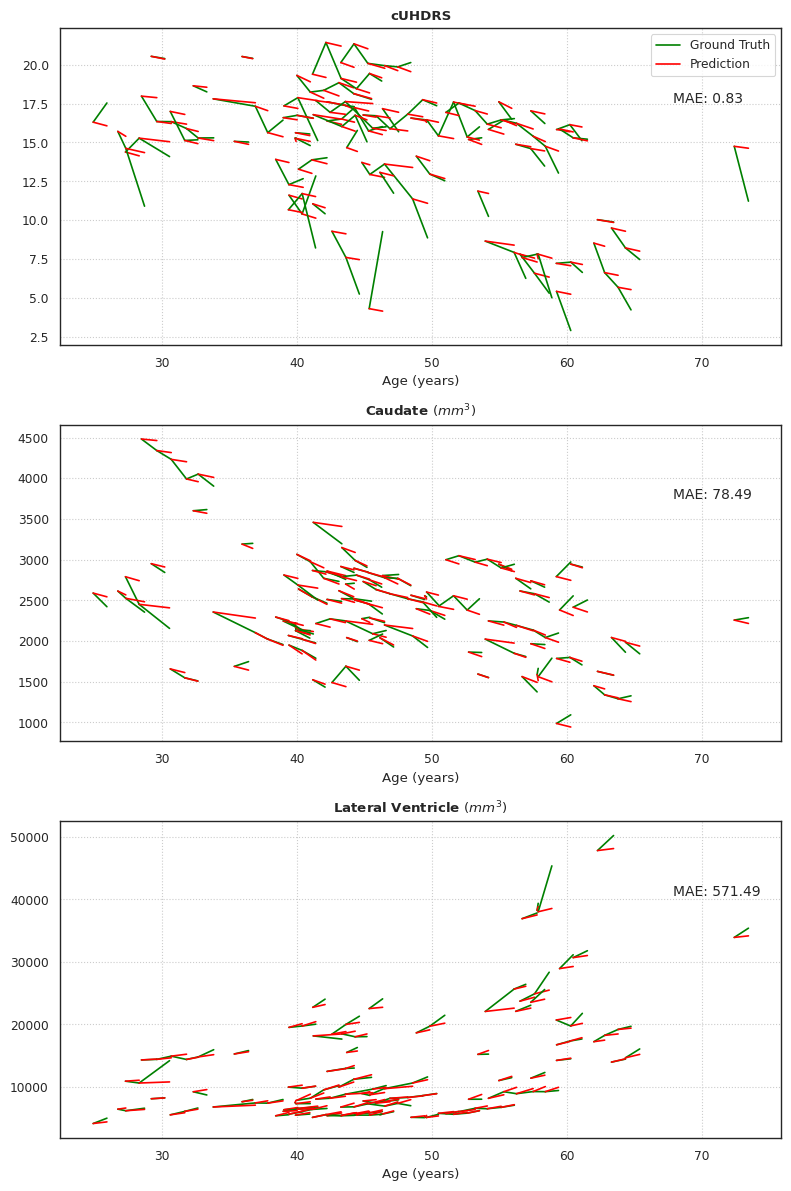

In [42]:
# Biomarkers and their corresponding column names in the DataFrame
titles = ["cUHDRS", "Caudate $(mm^3)$", "Lateral Ventricle $(mm^3)$"]
baseline_biomarkers = ["cUHDRS_t1", "vol_11_t1", "vol_4_t1"]
true_biomarkers = ["cUHDRS_t2", "vol_11_t2", "vol_4_t2"] # values at follow-up visit 
predicted_biomarkers = ["pred_cUHDRS_t2", "pred_vol_11_t2", "pred_vol_4_t2"]

A = scaler.scale_[[0, 4, 2]]
B = scaler.mean_[[0, 4, 2]]

# Plot settings
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Iterate through biomarkers
for i, (biomarker_t1, true_biomarker_t2, pred_biomarker_t2, title, ax) in enumerate(zip(baseline_biomarkers, true_biomarkers, predicted_biomarkers, titles, axes.flatten())):
    for subjid in df["subjid"].unique():
        subset = df[df["subjid"] == subjid]
        
        # Ensure data is sorted by age_t1 for smooth plotting
        subset = subset.sort_values(by="age_t1")

        # Get values for plotting
        age_t1 = subset["age_t1"].values
        age_t2 = subset["age_t2"].values
        true_values_t1 = subset[biomarker_t1].values
        true_values_t2 = subset[true_biomarker_t2].values
        pred_values_t2 = subset[pred_biomarker_t2].values

        true_values_t1 = A[i] * true_values_t1 + B[i]
        true_values_t2 = A[i] * true_values_t2 + B[i]
        pred_values_t2 = A[i] * pred_values_t2 + B[i]

        age_t1 = scaler.scale_[8] * age_t1 + scaler.mean_[8]
        age_t2 = scaler.scale_[8] * age_t2 + scaler.mean_[8]

        for j in range(1, len(true_values_t1)):

            # Ground truth: Draw an arrow from (age_t1, biomarker_t1) to (age_t2, biomarker_t2)
            ax.plot([age_t1[j], age_t2[j]], [true_values_t1[j], true_values_t2[j]], 'g-', label='Ground Truth' if j == 0 else "")
            ax.plot([age_t1[j], age_t2[j]], [true_values_t1[j], pred_values_t2[j]], 'r-', label='Prediction' if j == 0 else "")
           


    ax.set_xlabel("Age (years)")
    ax.set_title(title, fontweight="bold")
    ax.grid(linestyle=":")
    MAE = mean_absolute_error(A[i] * df[true_biomarker_t2].values + B[i]  ,  A[i] * df[pred_biomarker_t2].values + B[i])
    ax.text(0.85, 0.8, f'MAE: {MAE:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    if i == 0:  # Add legend only to the first subplot
        ax.legend(["Ground Truth", "Prediction"])

plt.tight_layout()
plt.savefig('shape-cvae.svg')
plt.show()

In [ ]:
# Plot settings
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Iterate through biomarkers
for i, (true_biomarker_t2, pred_biomarker_t2, title, ax) in enumerate(zip(true_biomarkers, predicted_biomarkers, titles, axes.flatten())):
    # Get the biomarker values at t2 and predictions
    true_values_t2 = df[true_biomarker_t2].values
    pred_values_t2 = df[pred_biomarker_t2].values

    # Apply scaling
    true_values_t2 = A[i] * true_values_t2 + B[i]
    pred_values_t2 = A[i] * pred_values_t2 + B[i]

    # Compute R² and MAE
    r2 = r2_score(true_values_t2, pred_values_t2)
    MAE = mean_absolute_error(true_values_t2, pred_values_t2)

    # Scatter plot of true values vs predicted values
    sns.scatterplot(x=true_values_t2, y=pred_values_t2, ax=ax)

    # Identity line: y = x
    ax.plot([min(true_values_t2), max(true_values_t2)], [min(true_values_t2), max(true_values_t2)], color='salmon', linestyle='--')

    # Display MAE and R²
    ax.text(0.7, 0.2, f'MAE: {MAE:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Set titles and labels
    ax.set_xlabel("Ground Truth at t2")
    ax.set_ylabel("Prediction at t2")
    ax.set_title(title, fontweight="bold")
    ax.grid(True)

    if i == 0:  # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.savefig('shape-pred-groundtruth.svg')
plt.show()


# **Naive** *Predictor*

In [30]:
# Initialize lists for DataFrame
data = {
    "subjid": [],
    "age_t1": [],
    "age_t2": [],
    "cUHDRS_t1": [],  # NEW: Store values at t1
    "cUHDRS_t2": [],
    "pred_cUHDRS_t2": [],
    "vol_4_t1": [],  # NEW: Store values at t1
    "vol_4_t2": [],
    "pred_vol_4_t2": [],
    "vol_11_t1": [],  # NEW: Store values at t1
    "vol_11_t2": [],
    "pred_vol_11_t2": [],
}

# Get unique subjects
unique_subjects = X_not_train_NORM["subjid"].unique()

# Iterate over unique subjects
for subj_id in tqdm(unique_subjects):
    subset = X_not_train_NORM[X_not_train_NORM["subjid"] == subj_id].sort_values(by="ageAtscan")

    ages = subset["ageAtscan"].values  # Convert to numpy for faster indexing
    CAPs = subset["CAP"].values
    ground_truths = subset[["cUHDRS", "Left-Lateral-Ventricle", "Left-Caudate"]].values

    subset_dataset = CustomDataset(subset)
    subset_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False)

    # Convert data to tensor
    cond_t1_list, target_t1_list , icv_t1_list = [], [] , []
    for _, target_t1, _ , _ , _, *_ in subset_loader:
        target_t1_list.append(target_t1.to(DEVICE))

    # Iterate over all consecutive (t1, t2) pairs
    for i in range(len(ages) - 1):
        if ages[i] == ages[i + 1]:
            continue  # Skip if consecutive ages are identical

        # Append data
        data["subjid"].append(subj_id)
        data["age_t1"].append(ages[i])
        data["age_t2"].append(ages[i + 1])

        # Store ground truths at t1 and t2
        data["cUHDRS_t1"].append(ground_truths[i, 0])
        data["cUHDRS_t2"].append(ground_truths[i + 1, 0])

        data["vol_4_t1"].append(ground_truths[i, 1])
        data["vol_4_t2"].append(ground_truths[i + 1, 1])

        data["vol_11_t1"].append(ground_truths[i, 2])
        data["vol_11_t2"].append(ground_truths[i + 1, 2])

        # Store predictions at t2
        data["pred_cUHDRS_t2"].append(ground_truths[i, 0])
        data["pred_vol_4_t2"].append(ground_truths[i, 1])
        data["pred_vol_11_t2"].append(ground_truths[i, 2])

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print('\n',df.head())


100%|██████████| 107/107 [03:56<00:00,  2.21s/it]


       subjid    age_t1    age_t2  cUHDRS_t1  cUHDRS_t2  pred_cUHDRS_t2  \
0  50_55.out -0.541434 -0.403667  -0.693763  -1.078616       -0.693763   
1  50_55.out -0.403667 -0.319147  -1.078616  -1.260698       -1.078616   
2  50_11.out  1.417043  1.556081  -1.587746  -1.369589       -1.587746   
3  50_11.out  1.556081  1.666871  -1.369589  -1.412481       -1.369589   
4  50_16.out  0.724650  0.877159   0.775991   0.790198        0.775991   

   vol_4_t1  vol_4_t2  pred_vol_4_t2  vol_11_t1  vol_11_t2  pred_vol_11_t2  
0  1.134631  1.366742       1.134631  -1.291830  -1.633350       -1.291830  
1  1.366742  1.544750       1.366742  -1.633350  -1.773756       -1.633350  
2  4.417236  4.787369       4.417236  -1.153448  -1.472708       -1.153448  
3  4.787369  5.115494       4.787369  -1.472708  -1.547269       -1.472708  
4 -0.395633 -0.231509      -0.395633   0.874809   0.578587        0.874809  


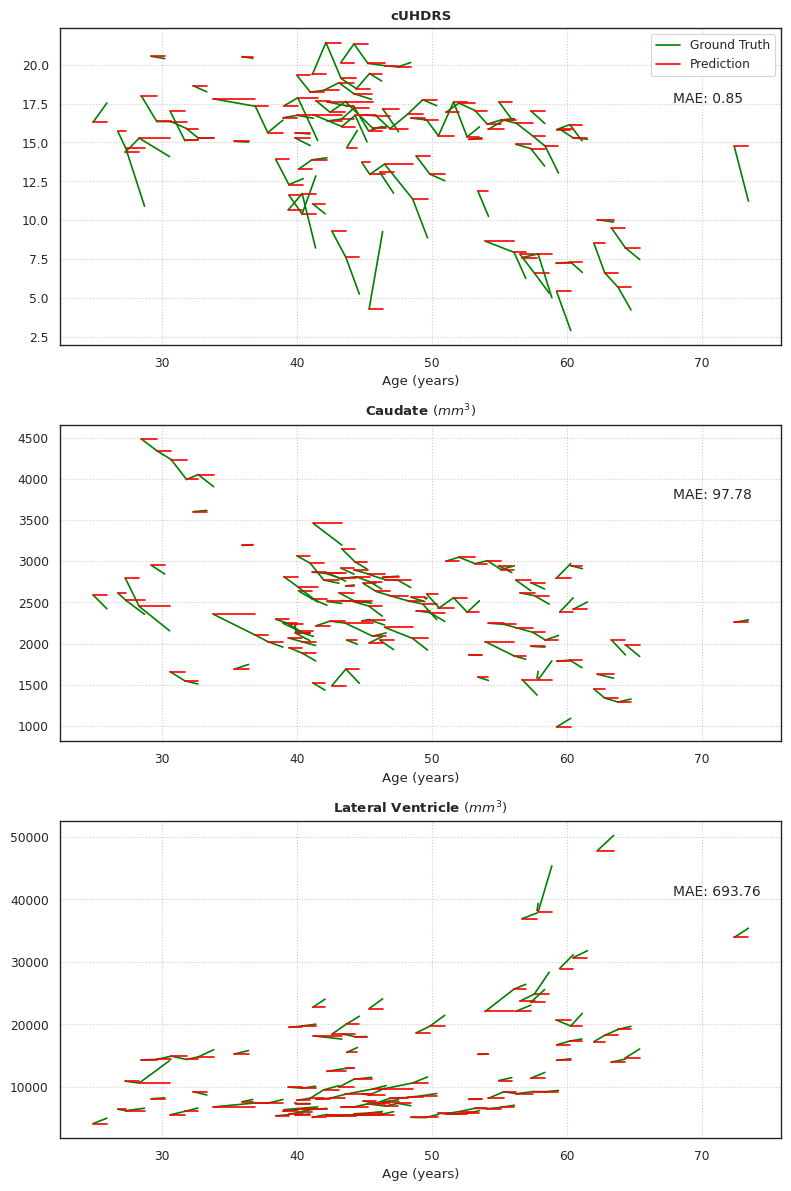

In [31]:
# Biomarkers and their corresponding column names in the DataFrame
titles = ["cUHDRS", "Caudate $(mm^3)$", "Lateral Ventricle $(mm^3)$"]
baseline_biomarkers = ["cUHDRS_t1", "vol_11_t1", "vol_4_t1"]
true_biomarkers = ["cUHDRS_t2", "vol_11_t2", "vol_4_t2"] # values at follow-up visit
predicted_biomarkers = ["pred_cUHDRS_t2", "pred_vol_11_t2", "pred_vol_4_t2"]

A = scaler.scale_[[0, 4, 2]]
B = scaler.mean_[[0, 4, 2]]

# Plot settings
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Iterate through biomarkers
for i, (biomarker_t1, true_biomarker_t2, pred_biomarker_t2, title, ax) in enumerate(zip(baseline_biomarkers, true_biomarkers, predicted_biomarkers, titles, axes.flatten())):
    for subjid in df["subjid"].unique():
        subset = df[df["subjid"] == subjid]

        # Ensure data is sorted by age_t1 for smooth plotting
        subset = subset.sort_values(by="age_t1")

        # Get values for plotting
        age_t1 = subset["age_t1"].values
        age_t2 = subset["age_t2"].values
        true_values_t1 = subset[biomarker_t1].values
        true_values_t2 = subset[true_biomarker_t2].values
        pred_values_t2 = subset[pred_biomarker_t2].values

        true_values_t1 = A[i] * true_values_t1 + B[i]
        true_values_t2 = A[i] * true_values_t2 + B[i]
        pred_values_t2 = A[i] * pred_values_t2 + B[i]

        age_t1 = scaler.scale_[8] * age_t1 + scaler.mean_[8]
        age_t2 = scaler.scale_[8] * age_t2 + scaler.mean_[8]

        for j in range(1, len(true_values_t1)):
            # Ground truth: Draw an arrow from (age_t1, biomarker_t1) to (age_t2, biomarker_t2)
            ax.plot([age_t1[j], age_t2[j]], [true_values_t1[j], true_values_t2[j]], 'g-', label='Ground Truth' if j == 0 else "")
            ax.plot([age_t1[j], age_t2[j]], [true_values_t1[j], pred_values_t2[j]], 'r-', label='Prediction' if j == 0 else "")

    ax.set_xlabel("Age (years)")
    ax.set_title(title, fontweight="bold")
    ax.grid(linestyle=":")
    MAE = mean_absolute_error(A[i] * df[true_biomarker_t2].values + B[i]  ,  A[i] * df[pred_biomarker_t2].values + B[i])
    ax.text(0.85, 0.8, f'MAE: {MAE:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    if i == 0:  # Add legend only to the first subplot
        ax.legend(["Ground Truth", "Prediction"])

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


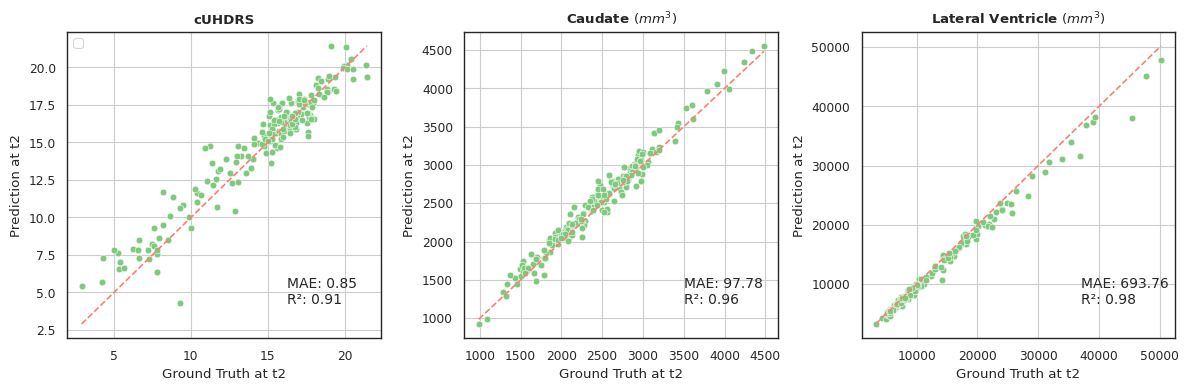

In [33]:
# Plot settings
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Iterate through biomarkers
for i, (true_biomarker_t2, pred_biomarker_t2, title, ax) in enumerate(zip(true_biomarkers, predicted_biomarkers, titles, axes.flatten())):
    # Get the biomarker values at t2 and predictions
    true_values_t2 = df[true_biomarker_t2].values
    pred_values_t2 = df[pred_biomarker_t2].values

    # Apply scaling
    true_values_t2 = A[i] * true_values_t2 + B[i]
    pred_values_t2 = A[i] * pred_values_t2 + B[i]

    # Compute R² and MAE
    r2 = r2_score(true_values_t2, pred_values_t2)
    MAE = mean_absolute_error(true_values_t2, pred_values_t2)

    # Scatter plot of true values vs predicted values
    sns.scatterplot(x=true_values_t2, y=pred_values_t2, ax=ax)

    # Identity line: y = x
    ax.plot([min(true_values_t2), max(true_values_t2)], [min(true_values_t2), max(true_values_t2)], color='salmon', linestyle='--')

    # Display MAE and R²
    ax.text(0.7, 0.2, f'MAE: {MAE:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Set titles and labels
    ax.set_xlabel("Ground Truth at t2")
    ax.set_ylabel("Prediction at t2")
    ax.set_title(title, fontweight="bold")
    ax.grid(True)

    if i == 0:  # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()


In [32]:
scaler.feature_names_in_

array(['cUHDRS', 'EstimatedTotalIntraCranialVol',
       'Left-Lateral-Ventricle', 'Left-Thalamus', 'Left-Caudate',
       'Left-Putamen', 'Left-Pallidum', 'Left-Accumbens-area',
       'ageAtscan', 'cag', 'CAP'], dtype=object)